In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import sys
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import sqlite3
import pandas_profiling
#from common_function import *

pd.options.display.max_columns = 999

In [2]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    

def reduce_mem_usage(df_):
    start_mem = df_.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for c in df_.columns[df_.dtypes != 'object']:
        col_type = df_[c].dtype
        
        c_min = df_[c].min()
        c_max = df_[c].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df_[c] = df_[c].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df_[c] = df_[c].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df_[c] = df_[c].astype(np.int32)
            else:
                df_[c] = df_[c].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_[c] = df_[c].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df_[c] = df_[c].astype(np.float32)
            else:
                df_[c] = df_[c].astype(np.float64)

    end_mem = df_.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df_

In [3]:
# Load the csv 
df_match_wide = pd.read_csv("data/ATP_matches.csv")

# Store the shape of the data for reference check later
original_shape = df_match_wide.shape

In [4]:
df_match_wide.columns

Index(['Winner', 'Loser', 'Tournament', 'Tournament_Date', 'Court_Surface',
       'Round_Description', 'Winner_Rank', 'Loser_Rank', 'Retirement_Ind',
       'Winner_Sets_Won', 'Winner_Games_Won', 'Winner_Aces',
       'Winner_DoubleFaults', 'Winner_FirstServes_Won',
       'Winner_FirstServes_In', 'Winner_SecondServes_Won',
       'Winner_SecondServes_In', 'Winner_BreakPoints_Won',
       'Winner_BreakPoints', 'Winner_ReturnPoints_Won',
       'Winner_ReturnPoints_Faced', 'Winner_TotalPoints_Won', 'Loser_Sets_Won',
       'Loser_Games_Won', 'Loser_Aces', 'Loser_DoubleFaults',
       'Loser_FirstServes_Won', 'Loser_FirstServes_In',
       'Loser_SecondServes_Won', 'Loser_SecondServes_In',
       'Loser_BreakPoints_Won', 'Loser_BreakPoints', 'Loser_ReturnPoints_Won',
       'Loser_ReturnPoints_Faced', 'Loser_TotalPoints_Won'],
      dtype='object')

In [5]:
# What are the big tournaments in the data
#df_match_wide.Tournament.value_counts().head()

df_match_wide.groupby(['Tournament','Court_Surface']).size().reset_index().sort_values(0, ascending=False).head()

,Tournament,Court_Surface,0
8,"Australian Open, Melbourne",Hard,1665
30,"French Open, Paris",Clay,1664
82,"U.S. Open, New York",Hard,1662
88,"Wimbledon, London",Grass,1106
36,Indian Wells,Hard,653


In [6]:
numeric_columns = ['Winner_Rank', 'Loser_Rank', 'Retirement_Ind',
                   'Winner_Sets_Won', 'Winner_Games_Won', 'Winner_Aces',
                   'Winner_DoubleFaults', 'Winner_FirstServes_Won',
                   'Winner_FirstServes_In', 'Winner_SecondServes_Won',
                   'Winner_SecondServes_In', 'Winner_BreakPoints_Won',
                   'Winner_BreakPoints', 'Winner_ReturnPoints_Won',
                   'Winner_ReturnPoints_Faced', 'Winner_TotalPoints_Won', 'Loser_Sets_Won',
                   'Loser_Games_Won', 'Loser_Aces', 'Loser_DoubleFaults',
                   'Loser_FirstServes_Won', 'Loser_FirstServes_In',
                   'Loser_SecondServes_Won', 'Loser_SecondServes_In',
                   'Loser_BreakPoints_Won', 'Loser_BreakPoints', 'Loser_ReturnPoints_Won',
                   'Loser_ReturnPoints_Faced', 'Loser_TotalPoints_Won']

text_columns = ['Winner', 'Loser',  'Tournament', 'Court_Surface','Round_Description'] 

date_columns = ['Tournament_Date']




In [7]:
# '.' in ['Winner_Rank']



In [8]:
df_match_wide[numeric_columns] = df_match_wide[numeric_columns].apply(pd.to_numeric,errors = 'coerce')
df_match_wide[date_columns] = df_match_wide[date_columns].apply(pd.to_datetime) 



In [9]:
missing_values_table(df_match_wide)

Your selected dataframe has 35 columns.
There are 25 columns that have missing values.


,Missing Values,% of Total Values
Winner_ReturnPoints_Won,376,1.8
Winner_ReturnPoints_Faced,376,1.8
Loser_ReturnPoints_Won,376,1.8
Loser_ReturnPoints_Faced,376,1.8
Loser_Rank,297,1.4
Winner_Rank,100,0.5
Winner_DoubleFaults,38,0.2
Loser_DoubleFaults,35,0.2
Round_Description,34,0.2
Loser_Aces,17,0.1


In [10]:
df_match_wide.loc[df_match_wide.Winner_ReturnPoints_Won.isna()]

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,Winner_Games_Won,Winner_Aces,Winner_DoubleFaults,Winner_FirstServes_Won,Winner_FirstServes_In,Winner_SecondServes_Won,Winner_SecondServes_In,Winner_BreakPoints_Won,Winner_BreakPoints,Winner_ReturnPoints_Won,Winner_ReturnPoints_Faced,Winner_TotalPoints_Won,Loser_Sets_Won,Loser_Games_Won,Loser_Aces,Loser_DoubleFaults,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won
1805,Marin Cilic,Sam Querrey,"Wimbledon, London",2012-06-25,Grass,Third Round,18.0,64.0,0,3.0,32,14.0,6.0,104.0,138.0,56.0,88.0,5.0,16.0,NaN,NaN,254,2.0,25,23.0,9.0,132.0,172.0,47.0,101.0,3.0,8.0,NaN,NaN,245
6158,Gilles Simon,Daniel Brands,"Australian Open, Melbourne",2014-01-13,Hard,First Round,19.0,59.0,0,3.0,27,32.0,18.0,114.0,143.0,57.0,114.0,4.0,10.0,NaN,NaN,230,2.0,21,41.0,4.0,109.0,129.0,36.0,75.0,2.0,25.0,NaN,NaN,231
8149,James Ward,Aldin Setkic,"U.S. Open, New York",2014-08-25,Hard,Qualifying,131.0,246.0,0,2.0,12,8.0,2.0,19.0,26.0,14.0,20.0,5.0,9.0,NaN,NaN,65,0.0,4,3.0,6.0,20.0,35.0,7.0,24.0,1.0,2.0,NaN,NaN,40
8160,Jimmy Wang,Daniel Evans,"U.S. Open, New York",2014-08-25,Hard,Qualifying,132.0,177.0,0,2.0,17,7.0,3.0,39.0,57.0,37.0,58.0,3.0,11.0,NaN,NaN,126,1.0,14,8.0,4.0,50.0,77.0,23.0,46.0,2.0,10.0,NaN,NaN,112
8161,Konstantin Kravchuk,Daniel Smethurst,"U.S. Open, New York",2014-08-25,Hard,Qualifying,220.0,255.0,0,2.0,12,11.0,1.0,24.0,28.0,7.0,13.0,5.0,12.0,NaN,NaN,61,0.0,3,0.0,1.0,13.0,36.0,8.0,15.0,1.0,2.0,NaN,NaN,31
8165,Sanam Singh,Flavio Cipolla,"U.S. Open, New York",2014-08-25,Hard,Qualifying,396.0,225.0,0,2.0,13,3.0,6.0,23.0,32.0,11.0,30.0,7.0,13.0,NaN,NaN,77,0.0,7,0.0,10.0,17.0,40.0,9.0,29.0,4.0,9.0,NaN,NaN,54
8170,Radu Albot,Gregoire Burquier,"U.S. Open, New York",2014-08-25,Hard,Qualifying,201.0,196.0,0,2.0,12,5.0,1.0,19.0,25.0,13.0,17.0,4.0,6.0,NaN,NaN,58,0.0,4,2.0,1.0,17.0,31.0,10.0,22.0,0.0,0.0,NaN,NaN,37
8171,Vincent Millot,Guido Pella,"U.S. Open, New York",2014-08-25,Hard,Qualifying,164.0,155.0,0,2.0,15,3.0,8.0,32.0,41.0,20.0,48.0,6.0,11.0,NaN,NaN,95,1.0,12,6.0,8.0,33.0,52.0,15.0,39.0,4.0,11.0,NaN,NaN,85
8180,Alex Bogomolov Jr.,Kimmer Coppejans,"U.S. Open, New York",2014-08-25,Hard,Qualifying,236.0,259.0,0,2.0,12,2.0,2.0,28.0,39.0,10.0,18.0,4.0,5.0,NaN,NaN,63,0.0,6,4.0,3.0,20.0,30.0,8.0,23.0,1.0,7.0,NaN,NaN,47
8198,Rhyne Williams,Roberto Carballes Baena,"U.S. Open, New York",2014-08-25,Hard,Qualifying,208.0,212.0,0,2.0,13,8.0,3.0,31.0,37.0,16.0,27.0,2.0,4.0,NaN,NaN,72,0.0,8,5.0,7.0,25.0,34.0,12.0,28.0,0.0,4.0,NaN,NaN,54


In [11]:
# df_match_wide.Tournament_Date = pd.to_datetime(df_match_wide.Tournament_Date,dayfirst=True)

In [12]:
df_match_wide['Total_Games'] = df_match_wide.Winner_Games_Won + df_match_wide.Loser_Games_Won



In [13]:
winner_cols = [col for col in df_match_wide.columns if col.startswith('Winner')]
# winner_cols.append()

# 'Tournament', 'Court_Surface','Round_Description']

# date_columns = ['Tournament_Date']
loser_cols = [col for col in df_match_wide.columns if col.startswith('Loser')]


In [14]:
df_winner = df_match_wide[winner_cols + ['Tournament','Tournament_Date', 'Court_Surface','Round_Description','Total_Games']]
df_loser = df_match_wide[loser_cols + ['Tournament','Tournament_Date', 'Court_Surface','Round_Description','Total_Games']]


df_winner["won"] = 1
df_loser["won"] = 0


player_cols = [col.replace('Winner','Player') for col in winner_cols]

# Rename the columns so that they are the same for winners and losers
df_winner.columns = player_cols + ['Tournament','Tournament_Date', 'Court_Surface',
                                   'Round_Description','Total_Games',"won"]
df_loser.columns  = df_winner.columns

In [15]:
# append the winner and loser dfs together so now the dataframe is in long format

df_match_long = df_winner.append(df_loser)

del df_winner
del df_loser
gc.collect()

0

In [16]:
def get_ratio_features(df):
    original_col = df.columns
    # Point Win ratio when serving
    df['F_Player_Serve_Win_Ratio'] = (df.Player_FirstServes_Won + df.Player_SecondServes_Won - df.Player_DoubleFaults) \
                                    /(df.Player_FirstServes_In + df.Player_SecondServes_In + df.Player_DoubleFaults)
    # Point win ratio when returning
    df['F_Player_Return_Win_Ratio'] = df.Player_ReturnPoints_Won / df.Player_ReturnPoints_Faced
    # Breakpoints per receiving game
    df['F_Player_BreakPoints_Per_Return_Game'] = df.Player_BreakPoints/df.Total_Games  
    df['F_Player_Game_Win_Percentage'] = df.Player_Games_Won/df.Total_Games

    ratio_columns = [col for col in df.columns if col not in original_col ]
    return df, ratio_columns

df_match_long,ratio_columns = get_ratio_features(df_match_long)

In [17]:
ratio_columns

['F_Player_Serve_Win_Ratio',
 'F_Player_Return_Win_Ratio',
 'F_Player_BreakPoints_Per_Return_Game',
 'F_Player_Game_Win_Percentage']

In [18]:
df_match_long.columns


Index(['Player', 'Player_Rank', 'Player_Sets_Won', 'Player_Games_Won',
       'Player_Aces', 'Player_DoubleFaults', 'Player_FirstServes_Won',
       'Player_FirstServes_In', 'Player_SecondServes_Won',
       'Player_SecondServes_In', 'Player_BreakPoints_Won',
       'Player_BreakPoints', 'Player_ReturnPoints_Won',
       'Player_ReturnPoints_Faced', 'Player_TotalPoints_Won', 'Tournament',
       'Tournament_Date', 'Court_Surface', 'Round_Description', 'Total_Games',
       'won', 'F_Player_Serve_Win_Ratio', 'F_Player_Return_Win_Ratio',
       'F_Player_BreakPoints_Per_Return_Game', 'F_Player_Game_Win_Percentage'],
      dtype='object')

In [19]:
# The long table should have exactly twice of the rows of the original data
assert df_match_long.shape[0] == original_shape[0]*2

In [20]:
df_match_long.head()

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Tournament,Tournament_Date,Court_Surface,Round_Description,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
0,Edouard Roger-Vasselin,106.0,2.0,12,5.0,2.0,22.0,30.0,12.0,19.0,4.0,7.0,25.0,59.0,59,Chennai,2012-01-02,Hard,First Round,19,1,0.627451,0.423729,0.368421,0.631579
1,Dudi Sela,83.0,2.0,12,2.0,0.0,14.0,17.0,11.0,16.0,6.0,14.0,36.0,58.0,61,Chennai,2012-01-02,Hard,First Round,13,1,0.757576,0.620690,1.076923,0.923077
2,Go Soeda,120.0,2.0,19,6.0,1.0,48.0,64.0,19.0,39.0,5.0,11.0,42.0,105.0,109,Chennai,2012-01-02,Hard,First Round,33,1,0.634615,0.400000,0.333333,0.575758
3,Yuki Bhambri,345.0,2.0,12,1.0,2.0,22.0,29.0,9.0,17.0,5.0,13.0,34.0,62.0,65,Chennai,2012-01-02,Hard,First Round,17,1,0.604167,0.548387,0.764706,0.705882
4,Yuichi Sugita,235.0,2.0,12,3.0,1.0,37.0,51.0,11.0,27.0,3.0,7.0,22.0,54.0,70,Chennai,2012-01-02,Hard,First Round,19,1,0.594937,0.407407,0.368421,0.631579


In [21]:
# tournaments that are similar to aus open which is french open and aus mel
tournament_train = ['French Open, Paris','Australian Open, Melbourne']

In [22]:
df_match_wide.loc[df_match_wide.Tournament.isin(tournament_train)].groupby(['Tournament','Tournament_Date']) \
.size().reset_index().sort_values(['Tournament','Tournament_Date'])

# check if there is more than one tournament date for each tournament per year

,Tournament,Tournament_Date,0
0,"Australian Open, Melbourne",2012-01-16,237
1,"Australian Open, Melbourne",2013-01-14,239
2,"Australian Open, Melbourne",2014-01-13,238
3,"Australian Open, Melbourne",2015-01-19,238
4,"Australian Open, Melbourne",2016-01-18,239
5,"Australian Open, Melbourne",2017-01-16,239
6,"Australian Open, Melbourne",2018-01-15,235
7,"French Open, Paris",2012-05-28,239
8,"French Open, Paris",2013-05-27,238
9,"French Open, Paris",2014-05-26,238


In [23]:
tournament_date_train = df_match_wide.loc[df_match_wide.Tournament.isin(tournament_train)].groupby(['Tournament','Tournament_Date']) \
.size().reset_index()[['Tournament','Tournament_Date']]


In [24]:
tournament_date_train.head()

,Tournament,Tournament_Date
0,"Australian Open, Melbourne",2012-01-16
1,"Australian Open, Melbourne",2013-01-14
2,"Australian Open, Melbourne",2014-01-13
3,"Australian Open, Melbourne",2015-01-19
4,"Australian Open, Melbourne",2016-01-18


In [25]:
# # some cells have . but we will convert them into null

# # stats_cols = ['Rank', 'Retirement_Ind', 'Sets_Won', 'Games_Won',
# #        'Aces', 'DoubleFaults', 'FirstServes_Won', 'FirstServes_In',
# #        'SecondServes_Won', 'SecondServes_In', 'BreakPoints_Won', 'BreakPoints',
# #        'ReturnPoints_Won', 'ReturnPoints_Faced', 'TotalPoints_Won', 'won',]



# df_match_long = df_match_long.sort_values(['Player','Tournament_Date','Tournament'], ascending=True)

In [26]:
# df_player = get_feature_period(df_player)

In [27]:

#df_match_long['Total_Games'] = df_match_long.FirstServes_Won


In [28]:
df_match_long.columns

Index(['Player', 'Player_Rank', 'Player_Sets_Won', 'Player_Games_Won',
       'Player_Aces', 'Player_DoubleFaults', 'Player_FirstServes_Won',
       'Player_FirstServes_In', 'Player_SecondServes_Won',
       'Player_SecondServes_In', 'Player_BreakPoints_Won',
       'Player_BreakPoints', 'Player_ReturnPoints_Won',
       'Player_ReturnPoints_Faced', 'Player_TotalPoints_Won', 'Tournament',
       'Tournament_Date', 'Court_Surface', 'Round_Description', 'Total_Games',
       'won', 'F_Player_Serve_Win_Ratio', 'F_Player_Return_Win_Ratio',
       'F_Player_BreakPoints_Per_Return_Game', 'F_Player_Game_Win_Percentage'],
      dtype='object')

In [29]:


def get_rolling_features (df, date_df=None,rolling_cols = None ):
    
    # Need to sort the data first so its from old to recent
    df = df.sort_values(['Player','Tournament_Date','Tournament'], ascending=True)
    
    # For each year, get the rolling averages of that player's past matches before the tournament start date
    for index, tournament_date in enumerate(date_df.Tournament_Date):
    
        # create a temp df to store the intrim results
        df_temp = df.loc[df.Tournament_Date < tournament_date]

        # take the most recent 20 matches for the rolling average
        df_temp = df_temp.groupby('Player')[rolling_cols].rolling(500, min_periods=1).mean().reset_index()
        df_temp = df_temp.groupby('Player').tail(1)

        if index ==0:
            # create the result dataframe
            df_result = df_temp
            # so we know which tournament this feature is for
            df_result['tournament_date_index'] = tournament_date
        else:
            df_temp['tournament_date_index'] = tournament_date
            df_result = df_result.append(df_temp)
    df_result.drop('level_1', axis=1,inplace=True)
    
    return df_result

In [30]:
# columns we are taking rolling averages from
rolling_cols = ['Player_Rank', 'Player_Sets_Won', 'Player_Games_Won',
           'Player_Aces', 'Player_DoubleFaults', 'Player_FirstServes_Won',
           'Player_FirstServes_In', 'Player_SecondServes_Won',
           'Player_SecondServes_In', 'Player_BreakPoints_Won',
           'Player_BreakPoints', 'Player_ReturnPoints_Won',
           'Player_ReturnPoints_Faced', 'Player_TotalPoints_Won', 'Total_Games',
           'won', 'F_Player_Serve_Win_Ratio', 'F_Player_Return_Win_Ratio',
           'F_Player_BreakPoints_Per_Return_Game', 'F_Player_Game_Win_Percentage']

    
df_result_long = get_rolling_features (df_match_long, tournament_date_train,rolling_cols )
    

In [31]:
df_match_long.shape

(41614, 25)

In [32]:
df_match_long.head(20)

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Tournament,Tournament_Date,Court_Surface,Round_Description,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
0,Edouard Roger-Vasselin,106.0,2.0,12,5.0,2.0,22.0,30.0,12.0,19.0,4.0,7.0,25.0,59.0,59,Chennai,2012-01-02,Hard,First Round,19,1,0.627451,0.423729,0.368421,0.631579
1,Dudi Sela,83.0,2.0,12,2.0,0.0,14.0,17.0,11.0,16.0,6.0,14.0,36.0,58.0,61,Chennai,2012-01-02,Hard,First Round,13,1,0.757576,0.620690,1.076923,0.923077
2,Go Soeda,120.0,2.0,19,6.0,1.0,48.0,64.0,19.0,39.0,5.0,11.0,42.0,105.0,109,Chennai,2012-01-02,Hard,First Round,33,1,0.634615,0.400000,0.333333,0.575758
3,Yuki Bhambri,345.0,2.0,12,1.0,2.0,22.0,29.0,9.0,17.0,5.0,13.0,34.0,62.0,65,Chennai,2012-01-02,Hard,First Round,17,1,0.604167,0.548387,0.764706,0.705882
4,Yuichi Sugita,235.0,2.0,12,3.0,1.0,37.0,51.0,11.0,27.0,3.0,7.0,22.0,54.0,70,Chennai,2012-01-02,Hard,First Round,19,1,0.594937,0.407407,0.368421,0.631579
5,Benoit Paire,95.0,2.0,12,8.0,2.0,24.0,25.0,11.0,19.0,4.0,8.0,27.0,52.0,62,Chennai,2012-01-02,Hard,First Round,15,1,0.717391,0.519231,0.533333,0.800000
6,Victor Hanescu,90.0,2.0,12,3.0,0.0,29.0,39.0,11.0,18.0,3.0,4.0,29.0,65.0,69,Chennai,2012-01-02,Hard,First Round,19,1,0.701754,0.446154,0.210526,0.631579
7,Yen-Hsun Lu,82.0,2.0,12,1.0,3.0,29.0,36.0,9.0,21.0,4.0,6.0,26.0,56.0,64,Chennai,2012-01-02,Hard,First Round,18,1,0.583333,0.464286,0.333333,0.666667
8,Andreas Beck,98.0,2.0,13,0.0,4.0,33.0,47.0,17.0,27.0,3.0,6.0,40.0,95.0,90,Chennai,2012-01-02,Hard,First Round,22,1,0.589744,0.421053,0.272727,0.590909
9,Ivan Dodig,36.0,2.0,17,8.0,2.0,47.0,65.0,20.0,36.0,3.0,3.0,32.0,86.0,99,Chennai,2012-01-02,Hard,First Round,30,1,0.631068,0.372093,0.100000,0.566667


In [33]:
example_true = df_match_long.loc[df_match_long.Player == 'Adam Pavlasek']

In [34]:
example_calculated = df_result_long.loc[df_result_long.Player == 'Adam Pavlasek']

In [35]:
example_true

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Tournament,Tournament_Date,Court_Surface,Round_Description,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
8917,Adam Pavlasek,240.0,2.0,13,5.0,1.0,28.0,37.0,15.0,25.0,3.0,7.0,NaN,NaN,71,"Australian Open, Melbourne",2015-01-19,Hard,Qualifying,20,1,0.666667,NaN,0.350000,0.650000
13080,Adam Pavlasek,132.0,2.0,15,9.0,3.0,42.0,66.0,15.0,30.0,5.0,11.0,40.0,88.0,97,"French Open, Paris",2016-05-23,Clay,Qualifying,28,1,0.545455,0.454545,0.392857,0.535714
13131,Adam Pavlasek,132.0,2.0,12,3.0,0.0,23.0,27.0,11.0,16.0,4.0,6.0,23.0,47.0,57,"French Open, Paris",2016-05-23,Clay,Qualifying,16,1,0.790698,0.489362,0.375000,0.750000
13214,Adam Pavlasek,132.0,3.0,23,7.0,2.0,66.0,102.0,26.0,53.0,8.0,17.0,61.0,135.0,153,"French Open, Paris",2016-05-23,Clay,First Round,41,1,0.573248,0.451852,0.414634,0.560976
13717,Adam Pavlasek,116.0,2.0,12,3.0,4.0,25.0,30.0,20.0,34.0,2.0,6.0,25.0,60.0,70,Kitzbuhel,2016-07-18,Clay,First Round,19,1,0.602941,0.416667,0.315789,0.631579
13725,Adam Pavlasek,116.0,2.0,12,6.0,2.0,24.0,32.0,14.0,25.0,4.0,5.0,21.0,45.0,59,Kitzbuhel,2016-07-18,Clay,Second Round,18,1,0.610169,0.466667,0.277778,0.666667
16571,Adam Pavlasek,136.0,3.0,24,14.0,5.0,59.0,70.0,17.0,33.0,8.0,18.0,55.0,127.0,131,"Wimbledon, London",2017-07-03,Grass,First Round,36,1,0.657407,0.433071,0.500000,0.666667
19109,Adam Pavlasek,185.0,1.0,6,0.0,1.0,9.0,17.0,7.0,17.0,4.0,5.0,18.0,26.0,34,"French Open, Paris",2018-05-28,Clay,Qualifying,9,1,0.428571,0.692308,0.555556,0.666667
19176,Adam Pavlasek,185.0,2.0,12,5.0,0.0,25.0,32.0,5.0,14.0,6.0,13.0,31.0,56.0,61,"French Open, Paris",2018-05-28,Clay,Qualifying,16,1,0.652174,0.553571,0.812500,0.750000
19198,Adam Pavlasek,185.0,2.0,13,7.0,2.0,42.0,60.0,14.0,25.0,2.0,8.0,31.0,81.0,87,"French Open, Paris",2018-05-28,Clay,Qualifying,23,1,0.620690,0.382716,0.347826,0.565217


In [36]:
example_calculated

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage,tournament_date_index
4,Adam Pavlasek,209.666667,1.000000,10.333333,8.333333,4.000000,37.000000,54.333333,23.333333,44.333333,2.000000,4.333333,NaN,NaN,90.000000,22.333333,0.333333,0.570862,NaN,0.195062,0.469136,2016-01-18
13,Adam Pavlasek,143.833333,1.333333,12.416667,6.250000,3.083333,36.666667,52.833333,17.833333,35.416667,2.833333,5.833333,29.000000,76.000000,83.666667,24.750000,0.500000,0.580659,0.382870,0.238815,0.513419,2017-01-16
20,Adam Pavlasek,129.894737,1.157895,11.842105,6.578947,3.368421,34.947368,50.842105,16.736842,35.210526,2.789474,6.105263,28.750000,77.687500,80.578947,25.263158,0.368421,0.544621,0.364698,0.233352,0.465603,2018-01-15
3,Adam Pavlasek,240.000000,1.500000,12.000000,11.500000,5.500000,47.000000,66.000000,26.500000,51.500000,2.500000,6.000000,NaN,NaN,109.000000,23.500000,0.500000,0.590164,NaN,0.267593,0.528704,2015-05-25
4,Adam Pavlasek,209.666667,1.000000,10.333333,8.333333,4.000000,37.000000,54.333333,23.333333,44.333333,2.000000,4.333333,NaN,NaN,90.000000,22.333333,0.333333,0.570862,NaN,0.195062,0.469136,2016-05-23
17,Adam Pavlasek,131.187500,1.125000,11.437500,6.312500,3.187500,34.500000,50.687500,16.562500,34.875000,2.562500,5.187500,27.076923,73.769231,78.625000,24.625000,0.375000,0.546238,0.367158,0.210731,0.467557,2017-05-29
21,Adam Pavlasek,133.800000,1.150000,12.000000,6.850000,3.250000,35.400000,51.650000,16.700000,35.100000,2.800000,6.000000,28.176471,78.235294,81.000000,25.550000,0.350000,0.546598,0.356091,0.228136,0.466517,2018-05-28


In [37]:
example_true.loc[example_true.Tournament_Date<'2018-01-15','Player_Rank'].mean()

129.89473684210526

In [38]:
example_true.shape

(28, 25)

In [39]:
example_true.loc[example_true.Tournament_Date<'2016-01-18','Player_Rank'].mean()

209.66666666666666

In [40]:
df_result_long.tail()

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage,tournament_date_index
38152,Yusuke Takahashi,262.000000,1.0,14.000000,4.000000,2.000000,28.000000,43.000000,22.000000,44.000000,4.000000,10.000000,36.00000,90.000000,86.000000,30.000000,0.000000,0.539326,0.400000,0.333333,0.466667,2018-05-28
38155,Zbynek Mlynarik,227.333333,1.0,10.666667,5.666667,6.333333,29.000000,38.666667,17.333333,41.666667,2.000000,5.666667,23.00000,74.000000,71.333333,23.666667,0.333333,0.455619,0.309642,0.239130,0.447930,2018-05-28
38190,Ze Zhang,202.085714,0.8,9.885714,3.485714,4.200000,29.942857,46.942857,11.771429,26.228571,2.371429,5.885714,24.71875,69.343750,67.685714,22.800000,0.285714,0.477999,0.345740,0.250178,0.418596,2018-05-28
38196,Zhe Li,258.666667,0.5,6.666667,2.500000,0.833333,23.000000,37.500000,9.166667,21.333333,1.166667,3.666667,17.50000,54.833333,49.666667,18.500000,0.166667,0.503743,0.302598,0.173115,0.329774,2018-05-28
38201,Zhizhen Zhang,530.200000,1.4,11.600000,5.800000,2.600000,30.600000,42.800000,15.800000,32.800000,2.400000,6.000000,26.60000,71.600000,73.000000,22.600000,0.600000,0.552725,0.366874,0.291449,0.515139,2018-05-28


In [41]:
# Randomise the match_wide dataset so the first player is not always the winner

# set a seed so the random number is reproducable
np.random.seed(2)

# randomise a number 0/1 with 50% chance each
# if 0 then take the winner, 1 then take loser

df_match_wide['random_number'] = np.random.randint(2, size=len(df_match_wide))

df_match_wide['randomised_player_1'] = np.where(df_match_wide['random_number']==0,df_match_wide['Winner'],df_match_wide['Loser'])
df_match_wide['randomised_player_2'] = np.where(df_match_wide['random_number']==0,df_match_wide['Loser'],df_match_wide['Winner'])

# set the target (win/loss) based on the new randomise number

df_match_wide['player_1_win'] = np.where(df_match_wide['random_number']==0,1,0)


In [42]:
df_match_wide.tail()

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,Winner_Games_Won,Winner_Aces,Winner_DoubleFaults,Winner_FirstServes_Won,Winner_FirstServes_In,Winner_SecondServes_Won,Winner_SecondServes_In,Winner_BreakPoints_Won,Winner_BreakPoints,Winner_ReturnPoints_Won,Winner_ReturnPoints_Faced,Winner_TotalPoints_Won,Loser_Sets_Won,Loser_Games_Won,Loser_Aces,Loser_DoubleFaults,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won,Total_Games,random_number,randomised_player_1,randomised_player_2,player_1_win
20802,Karen Khachanov,Novak Djokovic,Paris,2018-10-29,Indoor Hard,Finals,18.0,2.0,0,2.0,13,9.0,2.0,38.0,50.0,8.0,16.0,3.0,8.0,27.0,71.0,73,0.0,9,5.0,1.0,30.0,43.0,14.0,28.0,1.0,5.0,20.0,66.0,64,22,0,Karen Khachanov,Novak Djokovic,1
20803,Jaume Antoni Munar Clar,Frances Tiafoe,Milan,2018-11-05,Indoor Hard,NaN,76.0,40.0,0,3.0,12,7.0,1.0,25.0,27.0,16.0,19.0,2.0,4.0,19.0,46.0,60,0.0,5,6.0,3.0,21.0,29.0,6.0,17.0,0.0,2.0,5.0,46.0,32,17,0,Jaume Antoni Munar Clar,Frances Tiafoe,1
20804,Frances Tiafoe,Hubert Hurkacz,Milan,2018-11-05,Indoor Hard,NaN,40.0,85.0,0,3.0,14,11.0,1.0,39.0,53.0,17.0,25.0,2.0,7.0,22.0,67.0,78,1.0,10,9.0,4.0,35.0,48.0,10.0,19.0,1.0,7.0,22.0,78.0,67,24,1,Hubert Hurkacz,Frances Tiafoe,0
20805,Hubert Hurkacz,Jaume Antoni Munar Clar,Milan,2018-11-05,Indoor Hard,NaN,85.0,76.0,0,3.0,17,5.0,3.0,38.0,53.0,13.0,27.0,6.0,12.0,40.0,98.0,91,2.0,13,8.0,1.0,43.0,63.0,15.0,35.0,3.0,9.0,29.0,80.0,87,30,0,Hubert Hurkacz,Jaume Antoni Munar Clar,1
20806,Andrey Rublev,Liam Caruana,Milan,2018-11-05,Indoor Hard,NaN,68.0,NaN,0,3.0,12,9.0,2.0,33.0,39.0,6.0,18.0,3.0,5.0,21.0,53.0,60,0.0,6,6.0,1.0,28.0,39.0,4.0,14.0,1.0,3.0,18.0,57.0,50,18,1,Liam Caruana,Andrey Rublev,0


In [43]:
df_match_wide['random_number'].mean()

0.5032441005430864

In [44]:
df_match_wide['player_1_win'].mean()

0.49675589945691356

In [45]:
df_match_wide.head()

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,Winner_Games_Won,Winner_Aces,Winner_DoubleFaults,Winner_FirstServes_Won,Winner_FirstServes_In,Winner_SecondServes_Won,Winner_SecondServes_In,Winner_BreakPoints_Won,Winner_BreakPoints,Winner_ReturnPoints_Won,Winner_ReturnPoints_Faced,Winner_TotalPoints_Won,Loser_Sets_Won,Loser_Games_Won,Loser_Aces,Loser_DoubleFaults,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won,Total_Games,random_number,randomised_player_1,randomised_player_2,player_1_win
0,Edouard Roger-Vasselin,Eric Prodon,Chennai,2012-01-02,Hard,First Round,106.0,97.0,0,2.0,12,5.0,2.0,22.0,30.0,12.0,19.0,4.0,7.0,25.0,59.0,59,0.0,7,2.0,3.0,21.0,33.0,13.0,26.0,1.0,3.0,15.0,49.0,49,19,0,Edouard Roger-Vasselin,Eric Prodon,1
1,Dudi Sela,Fabio Fognini,Chennai,2012-01-02,Hard,First Round,83.0,48.0,0,2.0,12,2.0,0.0,14.0,17.0,11.0,16.0,6.0,14.0,36.0,58.0,61,0.0,1,1.0,4.0,17.0,32.0,5.0,26.0,0.0,1.0,8.0,33.0,30,13,1,Fabio Fognini,Dudi Sela,0
2,Go Soeda,Frederico Gil,Chennai,2012-01-02,Hard,First Round,120.0,102.0,0,2.0,19,6.0,1.0,48.0,64.0,19.0,39.0,5.0,11.0,42.0,105.0,109,1.0,14,5.0,2.0,45.0,70.0,18.0,35.0,2.0,4.0,36.0,103.0,99,33,1,Frederico Gil,Go Soeda,0
3,Yuki Bhambri,Karol Beck,Chennai,2012-01-02,Hard,First Round,345.0,101.0,0,2.0,12,1.0,2.0,22.0,29.0,9.0,17.0,5.0,13.0,34.0,62.0,65,0.0,5,1.0,1.0,15.0,33.0,13.0,29.0,2.0,3.0,15.0,46.0,43,17,0,Yuki Bhambri,Karol Beck,1
4,Yuichi Sugita,Olivier Rochus,Chennai,2012-01-02,Hard,First Round,235.0,67.0,0,2.0,12,3.0,1.0,37.0,51.0,11.0,27.0,3.0,7.0,22.0,54.0,70,0.0,7,0.0,0.0,19.0,32.0,13.0,22.0,1.0,7.0,30.0,78.0,62,19,0,Yuichi Sugita,Olivier Rochus,1


In [46]:
df_match_wide_train = df_match_wide.loc[df_match_wide.Tournament.isin(tournament_train), \
                                           ['Winner','Loser','Tournament','Tournament_Date',
                                           'player_1_win','randomised_player_1','randomised_player_2','random_number']]

# Get the rolling features

df_match_wide_train = df_match_wide_train.merge(df_result_long, how='left',
                         left_on = ['randomised_player_1','Tournament_Date'],
                         right_on = ['Player','tournament_date_index'],validate ='m:1')

df_match_wide_train = df_match_wide_train.merge(df_result_long, how='left',
                         left_on = ['randomised_player_2','Tournament_Date'],
                         right_on = ['Player','tournament_date_index'],validate ='m:1',suffixes=('_p1','_p2'))

In [47]:
df_match_wide_train.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,random_number,Player_p1,Player_Rank_p1,Player_Sets_Won_p1,Player_Games_Won_p1,Player_Aces_p1,Player_DoubleFaults_p1,Player_FirstServes_Won_p1,Player_FirstServes_In_p1,Player_SecondServes_Won_p1,Player_SecondServes_In_p1,Player_BreakPoints_Won_p1,Player_BreakPoints_p1,Player_ReturnPoints_Won_p1,Player_ReturnPoints_Faced_p1,Player_TotalPoints_Won_p1,Total_Games_p1,won_p1,F_Player_Serve_Win_Ratio_p1,F_Player_Return_Win_Ratio_p1,F_Player_BreakPoints_Per_Return_Game_p1,F_Player_Game_Win_Percentage_p1,tournament_date_index_p1,Player_p2,Player_Rank_p2,Player_Sets_Won_p2,Player_Games_Won_p2,Player_Aces_p2,Player_DoubleFaults_p2,Player_FirstServes_Won_p2,Player_FirstServes_In_p2,Player_SecondServes_Won_p2,Player_SecondServes_In_p2,Player_BreakPoints_Won_p2,Player_BreakPoints_p2,Player_ReturnPoints_Won_p2,Player_ReturnPoints_Faced_p2,Player_TotalPoints_Won_p2,Total_Games_p2,won_p2,F_Player_Serve_Win_Ratio_p2,F_Player_Return_Win_Ratio_p2,F_Player_BreakPoints_Per_Return_Game_p2,F_Player_Game_Win_Percentage_p2,tournament_date_index_p2
0,Adrian Menendez-Maceiras,Alejandro Gonzalez,"Australian Open, Melbourne",2012-01-16,1,Adrian Menendez-Maceiras,Alejandro Gonzalez,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,Marco Crugnola,Amir Weintraub,"Australian Open, Melbourne",2012-01-16,1,Marco Crugnola,Amir Weintraub,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,Sergei Bubka,Andre Begemann,"Australian Open, Melbourne",2012-01-16,0,Andre Begemann,Sergei Bubka,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Sergei Bubka,148.0,1.0,8.0,5.0,4.0,26.0,46.0,11.0,26.0,2.0,8.0,25.0,73.0,62.0,24.0,0.0,0.434211,0.342466,0.333333,0.333333,2012-01-16
3,Denys Molchanov,Andrew Harris,"Australian Open, Melbourne",2012-01-16,0,Andrew Harris,Denys Molchanov,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,Bjorn Phau,Arnaud Clement,"Australian Open, Melbourne",2012-01-16,0,Arnaud Clement,Bjorn Phau,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [48]:
df_match_wide_train.loc[df_match_wide_train.Player_p1.isna()].shape

(251, 52)

In [49]:
df_match_wide_train.loc[df_match_wide_train.Player_p1.isna(),'Tournament_Date'].value_counts()

2012-01-16    128
2012-05-28     23
2014-01-13     22
2013-01-14     19
2013-05-27     10
2018-01-15     10
2015-01-19      7
2017-05-29      7
2018-05-28      6
2017-01-16      5
2016-01-18      5
2014-05-26      4
2016-05-23      3
2015-05-25      2
Name: Tournament_Date, dtype: int64

In [50]:
df_match_wide_train.loc[
    (df_match_wide_train.Player_p1.isna())
    & (df_match_wide_train.Tournament_Date=='2018-01-15')
].head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,random_number,Player_p1,Player_Rank_p1,Player_Sets_Won_p1,Player_Games_Won_p1,Player_Aces_p1,Player_DoubleFaults_p1,Player_FirstServes_Won_p1,Player_FirstServes_In_p1,Player_SecondServes_Won_p1,Player_SecondServes_In_p1,Player_BreakPoints_Won_p1,Player_BreakPoints_p1,Player_ReturnPoints_Won_p1,Player_ReturnPoints_Faced_p1,Player_TotalPoints_Won_p1,Total_Games_p1,won_p1,F_Player_Serve_Win_Ratio_p1,F_Player_Return_Win_Ratio_p1,F_Player_BreakPoints_Per_Return_Game_p1,F_Player_Game_Win_Percentage_p1,tournament_date_index_p1,Player_p2,Player_Rank_p2,Player_Sets_Won_p2,Player_Games_Won_p2,Player_Aces_p2,Player_DoubleFaults_p2,Player_FirstServes_Won_p2,Player_FirstServes_In_p2,Player_SecondServes_Won_p2,Player_SecondServes_In_p2,Player_BreakPoints_Won_p2,Player_BreakPoints_p2,Player_ReturnPoints_Won_p2,Player_ReturnPoints_Faced_p2,Player_TotalPoints_Won_p2,Total_Games_p2,won_p2,F_Player_Serve_Win_Ratio_p2,F_Player_Return_Win_Ratio_p2,F_Player_BreakPoints_Per_Return_Game_p2,F_Player_Game_Win_Percentage_p2,tournament_date_index_p2
2862,Stefan Kozlov,Blake Ellis,"Australian Open, Melbourne",2018-01-15,0,Blake Ellis,Stefan Kozlov,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Stefan Kozlov,185.285714,0.741935,9.258065,2.903226,4.354839,24.645161,37.645161,13.064516,29.612903,2.709677,6.290323,25.833333,67.766667,63.548387,21.516129,0.258065,0.457146,0.368718,0.279110,0.416452,2018-01-15
2867,Di Wu,Dayne Kelly,"Australian Open, Melbourne",2018-01-15,0,Dayne Kelly,Di Wu,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Di Wu,216.666667,0.738095,9.309524,2.071429,2.595238,25.404762,39.547619,13.428571,28.238095,2.428571,5.880952,23.850000,64.250000,62.571429,20.785714,0.309524,0.511376,0.364905,0.282258,0.443278,2018-01-15
2870,Bjorn Propst,Facundo Bagnis,"Australian Open, Melbourne",2018-01-15,1,Bjorn Propst,Facundo Bagnis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Facundo Bagnis,115.388060,0.940299,10.776119,4.283582,3.313433,31.761194,46.656716,13.850746,28.358209,2.238806,5.865672,26.112903,72.080645,71.925373,22.895522,0.388060,0.537059,0.354205,0.252306,0.458755,2018-01-15
2879,Carlos Taberner,Joao Monteiro,"Australian Open, Melbourne",2018-01-15,1,Carlos Taberner,Joao Monteiro,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2888,Karim-Mohamed Maamoun,Marcelo Arevalo,"Australian Open, Melbourne",2018-01-15,1,Karim-Mohamed Maamoun,Marcelo Arevalo,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Marcelo Arevalo,219.333333,0.500000,9.666667,4.666667,3.000000,26.333333,40.000000,14.666667,26.166667,1.666667,3.666667,22.166667,66.500000,63.166667,22.000000,0.166667,0.578711,0.337123,0.187079,0.449343,2018-01-15


In [51]:
df_match_long.loc[df_match_long.Player=='Dayne Kelly']

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Tournament,Tournament_Date,Court_Surface,Round_Description,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
17915,Dayne Kelly,274.0,0.0,7,1.0,5.0,23.0,41.0,12.0,31.0,2.0,4.0,24.0,66.0,59,"Australian Open, Melbourne",2018-01-15,Hard,Qualifying,20,0,0.38961,0.363636,0.2,0.35


In [52]:
df_result_long.loc[df_result_long.Player=='Dayne Kelly']

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage,tournament_date_index
7010,Dayne Kelly,274.0,0.0,7.0,1.0,5.0,23.0,41.0,12.0,31.0,2.0,4.0,24.0,66.0,59.0,20.0,0.0,0.38961,0.363636,0.2,0.35,2018-05-28


In [53]:
df_match_wide_train.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,random_number,Player_p1,Player_Rank_p1,Player_Sets_Won_p1,Player_Games_Won_p1,Player_Aces_p1,Player_DoubleFaults_p1,Player_FirstServes_Won_p1,Player_FirstServes_In_p1,Player_SecondServes_Won_p1,Player_SecondServes_In_p1,Player_BreakPoints_Won_p1,Player_BreakPoints_p1,Player_ReturnPoints_Won_p1,Player_ReturnPoints_Faced_p1,Player_TotalPoints_Won_p1,Total_Games_p1,won_p1,F_Player_Serve_Win_Ratio_p1,F_Player_Return_Win_Ratio_p1,F_Player_BreakPoints_Per_Return_Game_p1,F_Player_Game_Win_Percentage_p1,tournament_date_index_p1,Player_p2,Player_Rank_p2,Player_Sets_Won_p2,Player_Games_Won_p2,Player_Aces_p2,Player_DoubleFaults_p2,Player_FirstServes_Won_p2,Player_FirstServes_In_p2,Player_SecondServes_Won_p2,Player_SecondServes_In_p2,Player_BreakPoints_Won_p2,Player_BreakPoints_p2,Player_ReturnPoints_Won_p2,Player_ReturnPoints_Faced_p2,Player_TotalPoints_Won_p2,Total_Games_p2,won_p2,F_Player_Serve_Win_Ratio_p2,F_Player_Return_Win_Ratio_p2,F_Player_BreakPoints_Per_Return_Game_p2,F_Player_Game_Win_Percentage_p2,tournament_date_index_p2
0,Adrian Menendez-Maceiras,Alejandro Gonzalez,"Australian Open, Melbourne",2012-01-16,1,Adrian Menendez-Maceiras,Alejandro Gonzalez,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,Marco Crugnola,Amir Weintraub,"Australian Open, Melbourne",2012-01-16,1,Marco Crugnola,Amir Weintraub,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,Sergei Bubka,Andre Begemann,"Australian Open, Melbourne",2012-01-16,0,Andre Begemann,Sergei Bubka,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Sergei Bubka,148.0,1.0,8.0,5.0,4.0,26.0,46.0,11.0,26.0,2.0,8.0,25.0,73.0,62.0,24.0,0.0,0.434211,0.342466,0.333333,0.333333,2012-01-16
3,Denys Molchanov,Andrew Harris,"Australian Open, Melbourne",2012-01-16,0,Andrew Harris,Denys Molchanov,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,Bjorn Phau,Arnaud Clement,"Australian Open, Melbourne",2012-01-16,0,Arnaud Clement,Bjorn Phau,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [54]:
df_match_wide_train['p1_na_flag'] = np.where(df_match_wide_train.Player_p1.isna(),1,0)
df_match_wide_train['p2_na_flag'] = np.where(df_match_wide_train.Player_p2.isna(),1,0)


In [55]:
rolling_cols

['Player_Rank',
 'Player_Sets_Won',
 'Player_Games_Won',
 'Player_Aces',
 'Player_DoubleFaults',
 'Player_FirstServes_Won',
 'Player_FirstServes_In',
 'Player_SecondServes_Won',
 'Player_SecondServes_In',
 'Player_BreakPoints_Won',
 'Player_BreakPoints',
 'Player_ReturnPoints_Won',
 'Player_ReturnPoints_Faced',
 'Player_TotalPoints_Won',
 'Total_Games',
 'won',
 'F_Player_Serve_Win_Ratio',
 'F_Player_Return_Win_Ratio',
 'F_Player_BreakPoints_Per_Return_Game',
 'F_Player_Game_Win_Percentage']

In [56]:
df_p1 = df_match_wide_train[['Player_Rank_p1', 'Player_Sets_Won_p1',
       'Player_Games_Won_p1', 'Player_Aces_p1', 'Player_DoubleFaults_p1',
       'Player_FirstServes_Won_p1', 'Player_FirstServes_In_p1',
       'Player_SecondServes_Won_p1', 'Player_SecondServes_In_p1',
       'Player_BreakPoints_Won_p1', 'Player_BreakPoints_p1',
       'Player_ReturnPoints_Won_p1', 'Player_ReturnPoints_Faced_p1',
       'Player_TotalPoints_Won_p1', 'Total_Games_p1', 'won_p1',
       'F_Player_Serve_Win_Ratio_p1', 'F_Player_Return_Win_Ratio_p1',
       'F_Player_BreakPoints_Per_Return_Game_p1',
       'F_Player_Game_Win_Percentage_p1']].fillna(-1)

df_p2 = df_match_wide_train[['Player_Rank_p2', 'Player_Sets_Won_p2',
       'Player_Games_Won_p2', 'Player_Aces_p2', 'Player_DoubleFaults_p2',
       'Player_FirstServes_Won_p2', 'Player_FirstServes_In_p2',
       'Player_SecondServes_Won_p2', 'Player_SecondServes_In_p2',
       'Player_BreakPoints_Won_p2', 'Player_BreakPoints_p2',
       'Player_ReturnPoints_Won_p2', 'Player_ReturnPoints_Faced_p2',
       'Player_TotalPoints_Won_p2', 'Total_Games_p2', 'won_p2',
       'F_Player_Serve_Win_Ratio_p2', 'F_Player_Return_Win_Ratio_p2',
       'F_Player_BreakPoints_Per_Return_Game_p2',
       'F_Player_Game_Win_Percentage_p2']].fillna(-1)

df_p1.columns = rolling_cols
df_p2.columns = rolling_cols

In [57]:
df_diff = df_p1- df_p2

In [58]:
df_p1.tail(2)

,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
3327,118.220339,0.847458,10.406780,3.457627,2.355932,32.322034,48.457627,11.457627,24.644068,2.067797,5.559322,24.785714,71.250000,68.305085,23.016949,0.305085,0.547021,0.343780,0.243822,0.450930
3328,3.785542,1.959036,14.240964,2.915663,1.603865,35.708434,49.342169,12.691566,22.274699,4.000000,8.836145,32.756627,76.568675,81.214458,23.568675,0.833735,0.649959,0.438925,0.400675,0.624391


In [59]:
df_p2.tail(2)

,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
3327,31.848684,1.539474,13.299342,5.845395,2.855263,33.845395,45.690789,16.917763,31.782895,2.894737,7.710526,30.76412,81.448505,81.611842,25.167763,0.644737,0.601141,0.37837,0.315272,0.532536
3328,31.848684,1.539474,13.299342,5.845395,2.855263,33.845395,45.690789,16.917763,31.782895,2.894737,7.710526,30.76412,81.448505,81.611842,25.167763,0.644737,0.601141,0.37837,0.315272,0.532536


In [60]:
df_diff.tail(2)

,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,Player_BreakPoints_Won,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,won,F_Player_Serve_Win_Ratio,F_Player_Return_Win_Ratio,F_Player_BreakPoints_Per_Return_Game,F_Player_Game_Win_Percentage
3327,86.371655,-0.692016,-2.892562,-2.387768,-0.499331,-1.523361,2.766838,-5.460136,-7.138827,-0.826940,-2.151204,-5.978405,-10.198505,-13.306757,-2.150814,-0.339652,-0.054120,-0.034590,-0.071450,-0.081606
3328,-28.063142,0.419562,0.941622,-2.929732,-1.251398,1.863039,3.651379,-4.226197,-9.508196,1.105263,1.125618,1.992507,-4.879830,-0.397384,-1.599088,0.188998,0.048819,0.060556,0.085404,0.091855


In [61]:
drop_cols = ['Player_Rank_p1', 'Player_Sets_Won_p1',
       'Player_Games_Won_p1', 'Player_Aces_p1', 'Player_DoubleFaults_p1',
       'Player_FirstServes_Won_p1', 'Player_FirstServes_In_p1',
       'Player_SecondServes_Won_p1', 'Player_SecondServes_In_p1',
       'Player_BreakPoints_Won_p1', 'Player_BreakPoints_p1',
       'Player_ReturnPoints_Won_p1', 'Player_ReturnPoints_Faced_p1',
       'Player_TotalPoints_Won_p1', 'Total_Games_p1', 'won_p1',
       'F_Player_Serve_Win_Ratio_p1', 'F_Player_Return_Win_Ratio_p1',
       'F_Player_BreakPoints_Per_Return_Game_p1',
       'F_Player_Game_Win_Percentage_p1'] +  \
            ['Player_Rank_p2', 'Player_Sets_Won_p2',
       'Player_Games_Won_p2', 'Player_Aces_p2', 'Player_DoubleFaults_p2',
       'Player_FirstServes_Won_p2', 'Player_FirstServes_In_p2',
       'Player_SecondServes_Won_p2', 'Player_SecondServes_In_p2',
       'Player_BreakPoints_Won_p2', 'Player_BreakPoints_p2',
       'Player_ReturnPoints_Won_p2', 'Player_ReturnPoints_Faced_p2',
       'Player_TotalPoints_Won_p2', 'Total_Games_p2', 'won_p2',
       'F_Player_Serve_Win_Ratio_p2', 'F_Player_Return_Win_Ratio_p2',
       'F_Player_BreakPoints_Per_Return_Game_p2',
       'F_Player_Game_Win_Percentage_p2'] \
    +  ['random_number','Player_p1','tournament_date_index_p1','Player_p2','tournament_date_index_p2']

In [62]:
df_match_wide_train.drop(drop_cols, axis =1, inplace=True)

In [63]:
df_match_wide_train.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,p1_na_flag,p2_na_flag
0,Adrian Menendez-Maceiras,Alejandro Gonzalez,"Australian Open, Melbourne",2012-01-16,1,Adrian Menendez-Maceiras,Alejandro Gonzalez,1,1
1,Marco Crugnola,Amir Weintraub,"Australian Open, Melbourne",2012-01-16,1,Marco Crugnola,Amir Weintraub,1,1
2,Sergei Bubka,Andre Begemann,"Australian Open, Melbourne",2012-01-16,0,Andre Begemann,Sergei Bubka,1,0
3,Denys Molchanov,Andrew Harris,"Australian Open, Melbourne",2012-01-16,0,Andrew Harris,Denys Molchanov,1,1
4,Bjorn Phau,Arnaud Clement,"Australian Open, Melbourne",2012-01-16,0,Arnaud Clement,Bjorn Phau,1,1


In [64]:
df_match_wide_train.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,p1_na_flag,p2_na_flag
0,Adrian Menendez-Maceiras,Alejandro Gonzalez,"Australian Open, Melbourne",2012-01-16,1,Adrian Menendez-Maceiras,Alejandro Gonzalez,1,1
1,Marco Crugnola,Amir Weintraub,"Australian Open, Melbourne",2012-01-16,1,Marco Crugnola,Amir Weintraub,1,1
2,Sergei Bubka,Andre Begemann,"Australian Open, Melbourne",2012-01-16,0,Andre Begemann,Sergei Bubka,1,0
3,Denys Molchanov,Andrew Harris,"Australian Open, Melbourne",2012-01-16,0,Andrew Harris,Denys Molchanov,1,1
4,Bjorn Phau,Arnaud Clement,"Australian Open, Melbourne",2012-01-16,0,Arnaud Clement,Bjorn Phau,1,1


In [65]:
df_match_wide_train.shape

(3329, 9)

In [66]:
df_diff.shape

(3329, 20)

In [67]:
df_train = pd.concat([df_match_wide_train, df_diff], axis=1)

In [68]:
df_train.shape

(3329, 29)

In [69]:
df_train.columns

Index(['Winner', 'Loser', 'Tournament', 'Tournament_Date', 'player_1_win',
       'randomised_player_1', 'randomised_player_2', 'p1_na_flag',
       'p2_na_flag', 'Player_Rank', 'Player_Sets_Won', 'Player_Games_Won',
       'Player_Aces', 'Player_DoubleFaults', 'Player_FirstServes_Won',
       'Player_FirstServes_In', 'Player_SecondServes_Won',
       'Player_SecondServes_In', 'Player_BreakPoints_Won',
       'Player_BreakPoints', 'Player_ReturnPoints_Won',
       'Player_ReturnPoints_Faced', 'Player_TotalPoints_Won', 'Total_Games',
       'won', 'F_Player_Serve_Win_Ratio', 'F_Player_Return_Win_Ratio',
       'F_Player_BreakPoints_Per_Return_Game', 'F_Player_Game_Win_Percentage'],
      dtype='object')

In [71]:

df_valid = df_train.loc[df_train.Tournament_Date == '2018-01-15']
df_train = df_train.loc[df_train.Tournament_Date < '2018-01-15']

In [72]:
df_valid.shape

(235, 29)

In [73]:
df_train.shape

(2856, 29)

In [74]:
drop_col = ['Winner', 'Loser', 'Tournament', 'Tournament_Date','randomised_player_1', 'randomised_player_2']
df_train.drop(drop_col, axis=1, inplace=True)
df_valid.drop(drop_col, axis=1, inplace=True)

feats = [col for col in df_train.columns if col != 'player_1_win']
target= 'player_1_win'

In [75]:
X_train, y_train = df_train[feats],df_train[target]
X_valid, y_valid = df_valid[feats],df_valid[target]




In [80]:
import lightgbm


train_data_lgb = lightgbm.Dataset(X_train, label=y_train)
valid_data_lgb = lightgbm.Dataset(X_valid, label=y_valid)


gc.collect()

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 30, #31
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.1, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}


clf_LGB = lightgbm.train(parameters,
                         train_data_lgb,
                         #valid_sets=[valid_data_lgb,holdout_data_lgb],
                         valid_sets=[train_data_lgb,valid_data_lgb],
                         num_boost_round=1000,
                         early_stopping_rounds=30,
                         verbose_eval=10)

Training until validation scores don't improve for 30 rounds.
[10]	training's binary_logloss: 0.562377	valid_1's binary_logloss: 0.664975
[20]	training's binary_logloss: 0.504094	valid_1's binary_logloss: 0.687583
[30]	training's binary_logloss: 0.463463	valid_1's binary_logloss: 0.693249
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.58787	valid_1's binary_logloss: 0.661678


In [77]:
import shap

# load JS visualization code to notebook
shap.initjs()


# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf_LGB)
shap_values = explainer.shap_values(X_train)


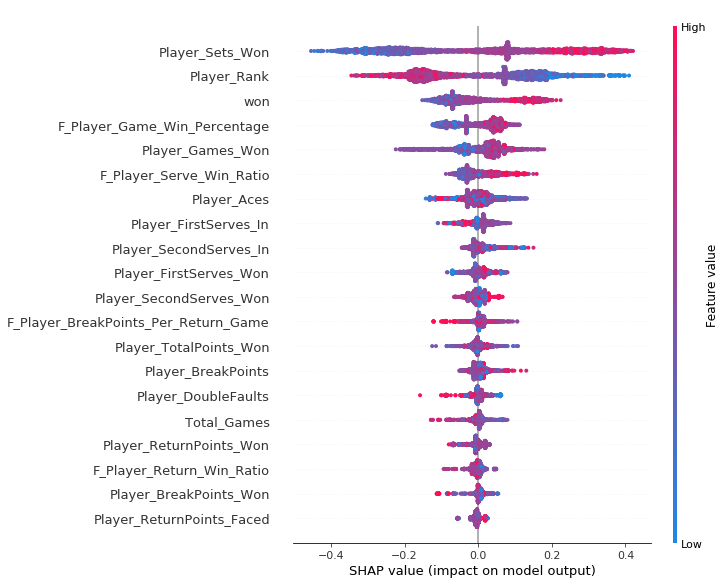

In [78]:
shap.summary_plot(shap_values, X_train)


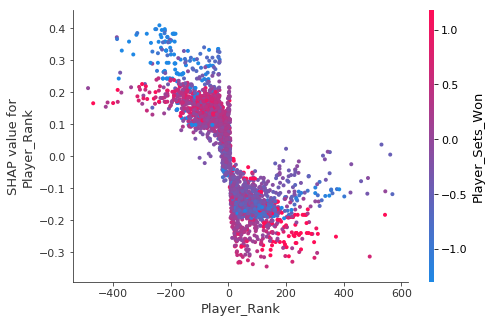

In [82]:
shap.dependence_plot("Player_Rank", shap_values, X_train)


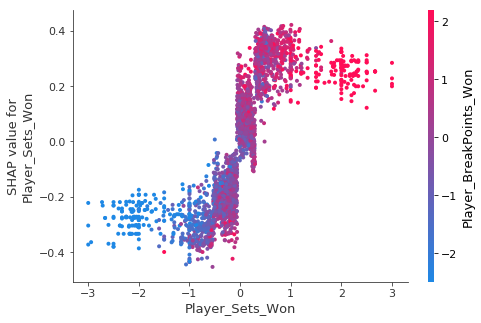

In [84]:
shap.dependence_plot("Player_Sets_Won", shap_values, X_train)
